In [1]:
#This code take the Qiskit Community Tutorial on Quantum Animations by @quantumjim and extends it to represent quantum emojis.
#Team 61 in the qiskit camp Europe argue that emotions are best represented in a quantum way. Therefore to represent this 
#we use quantum animations to blue various emojis together, highlighting the complexity and plurality of our 
#emotional states. Written by @libby-h


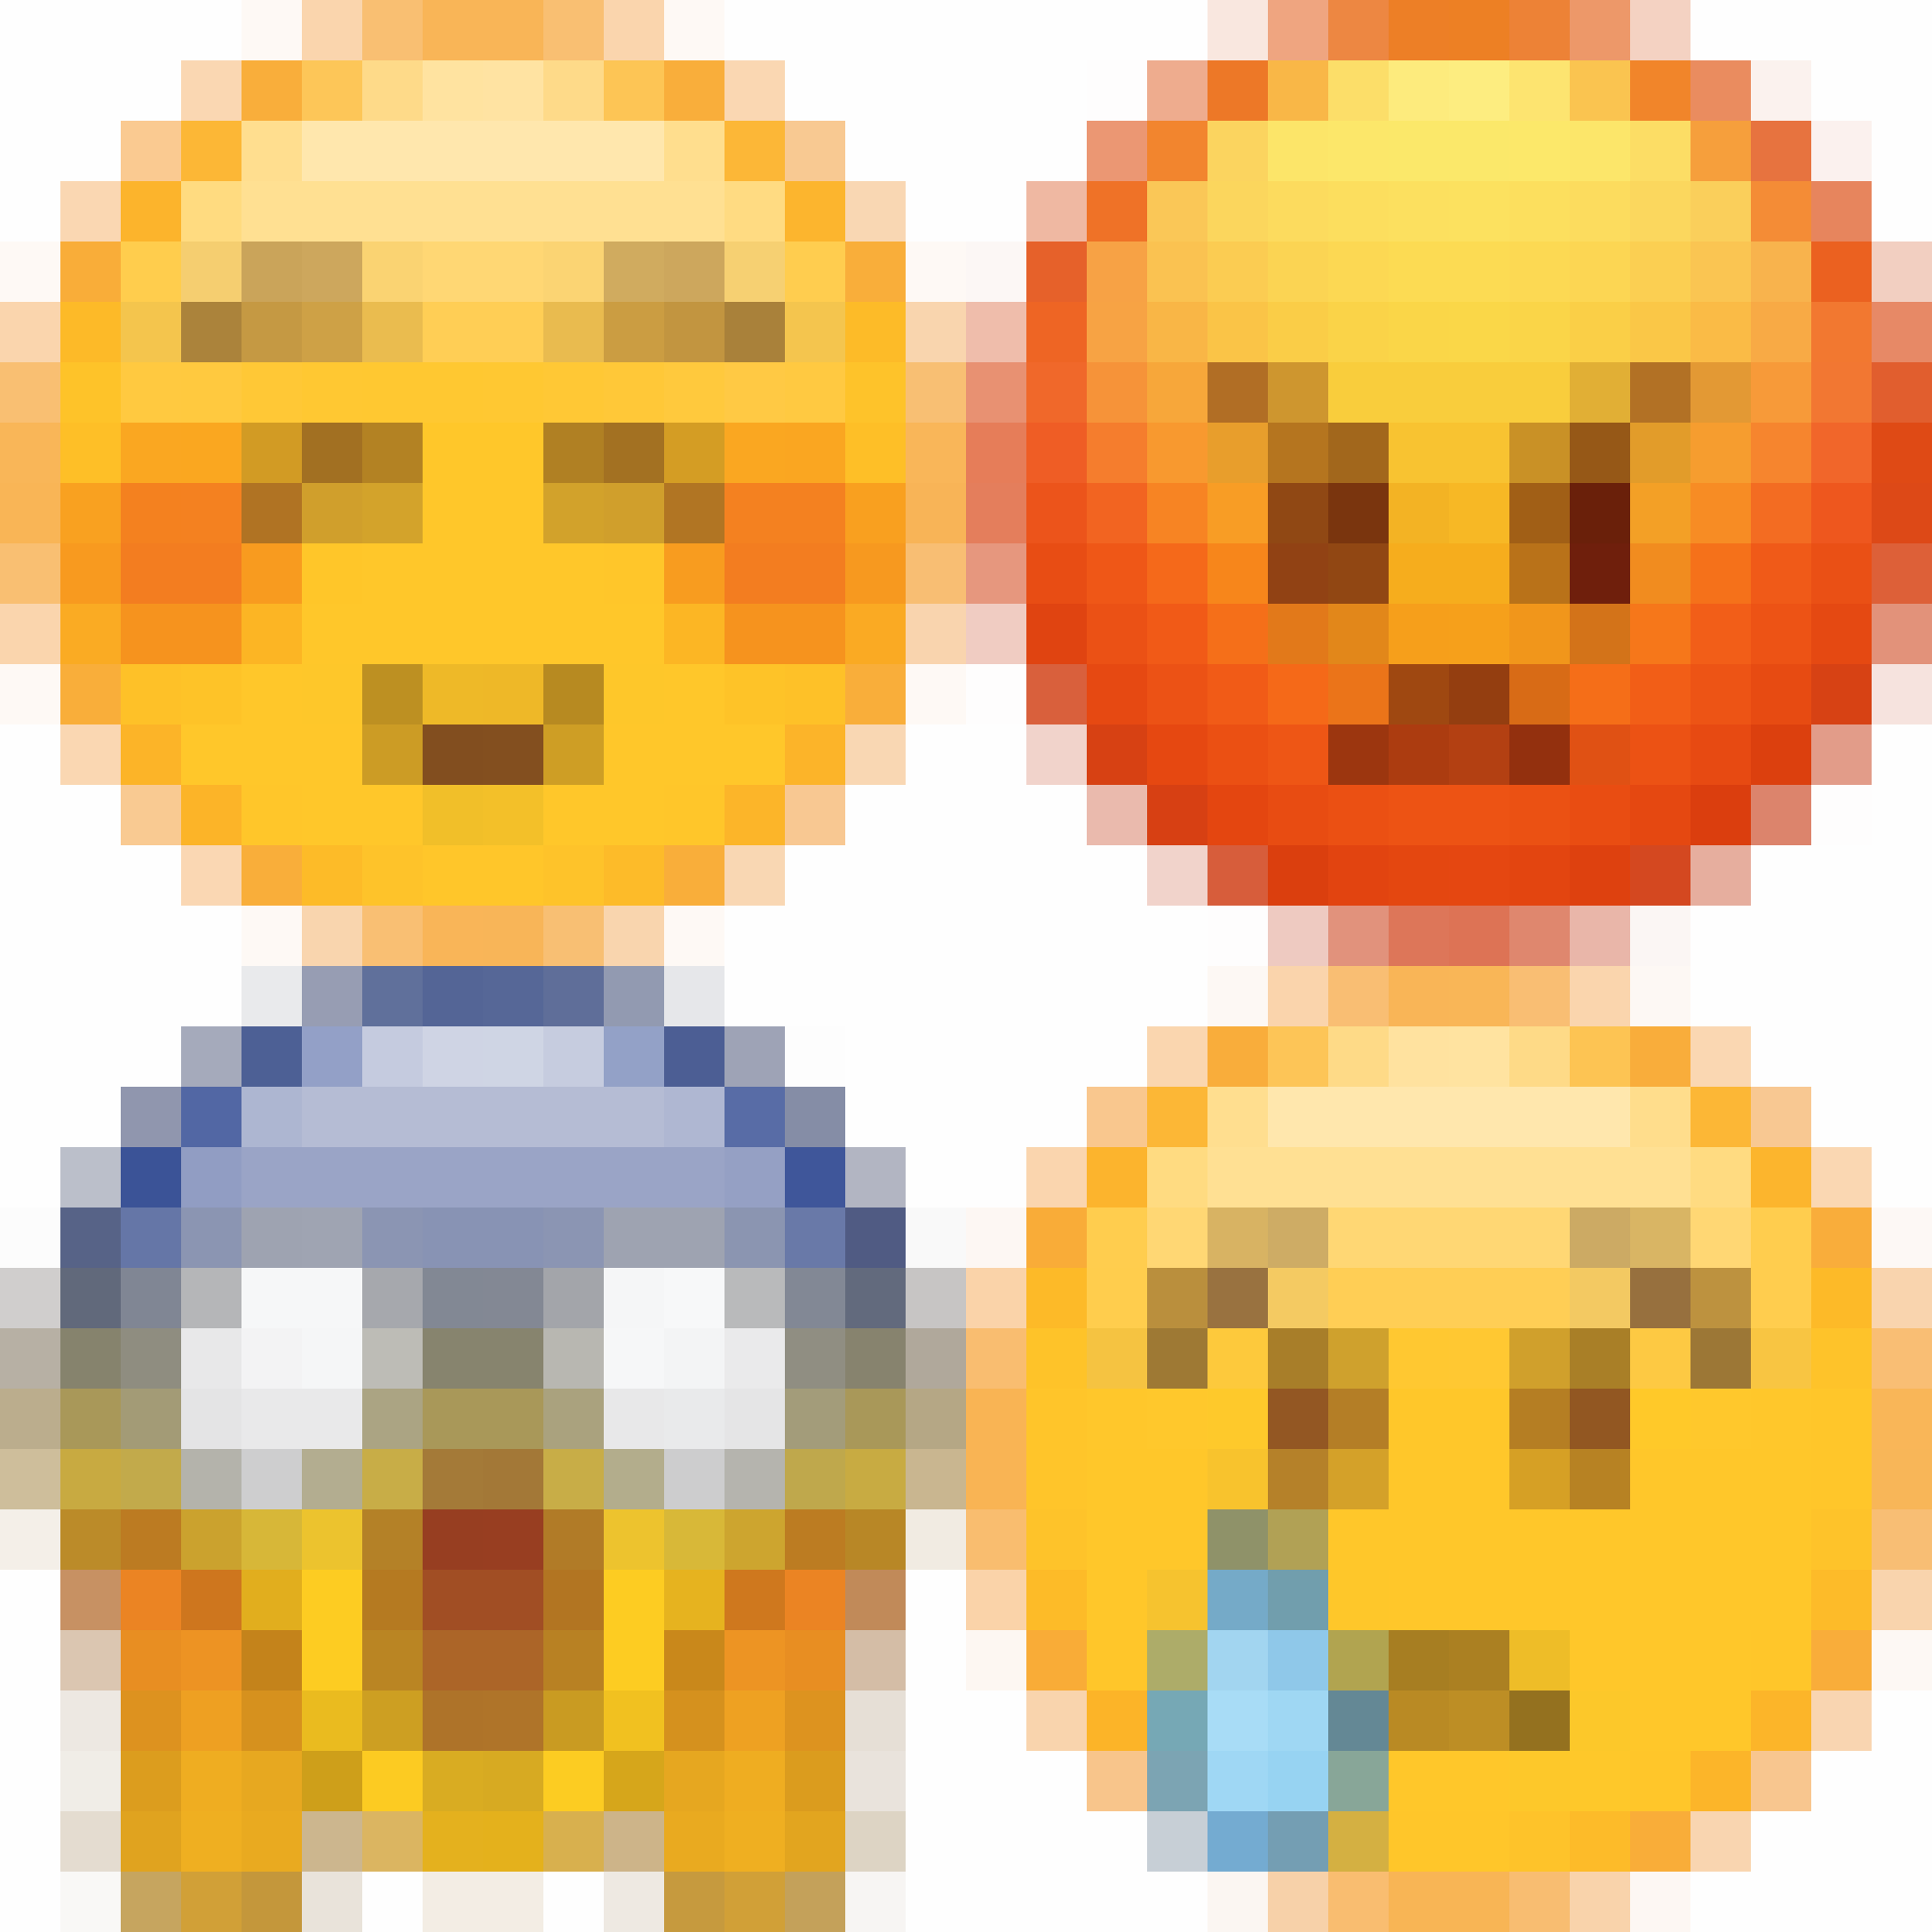

In [2]:
from PIL import Image
from IPython.display import display

smiley = Image.open("happy_angry_scared_sad.png")
display(Image.open("happy_angry_scared_sad.png"))

In [3]:
n=10 #number qubits
L = int(2**(n/2)) #number of squares in image


In [4]:
pix = smiley.load()
rgb_im = smiley.convert('RGB')
r, g, b = rgb_im.getpixel((1, 1))
pix_size = 64 #how many physical pixels are in the length of the big square pixels in the image


In [5]:
rgb_dict = {} #create a dict of the rgb values for the big square pixels in the image
for y in range(0,L):
    for x in range(0,L):
        pixel_x = x*pix_size
        pixel_y = y*pix_size
        r, g, b = rgb_im.getpixel((pixel_x, pixel_y)) 
        rgb_dict[(x,y)] = (r,g,b)
print(rgb_dict)

{(0, 0): (254, 254, 254), (1, 0): (254, 254, 254), (2, 0): (254, 254, 254), (3, 0): (254, 254, 254), (4, 0): (254, 249, 245), (5, 0): (250, 213, 173), (6, 0): (249, 191, 114), (7, 0): (249, 181, 86), (8, 0): (249, 181, 86), (9, 0): (249, 191, 114), (10, 0): (250, 213, 173), (11, 0): (254, 249, 245), (12, 0): (254, 254, 254), (13, 0): (254, 254, 254), (14, 0): (254, 254, 254), (15, 0): (254, 254, 254), (16, 0): (254, 254, 254), (17, 0): (254, 254, 254), (18, 0): (254, 254, 254), (19, 0): (254, 254, 254), (20, 0): (249, 231, 223), (21, 0): (239, 165, 128), (22, 0): (237, 135, 66), (23, 0): (237, 127, 38), (24, 0): (237, 128, 36), (25, 0): (237, 130, 54), (26, 0): (237, 152, 105), (27, 0): (244, 210, 194), (28, 0): (254, 254, 254), (29, 0): (254, 254, 254), (30, 0): (254, 254, 254), (31, 0): (254, 254, 254), (0, 1): (254, 254, 254), (1, 1): (254, 254, 254), (2, 1): (254, 254, 254), (3, 1): (250, 215, 178), (4, 1): (249, 174, 59), (5, 1): (253, 198, 88), (6, 1): (254, 218, 137), (7, 1): (2

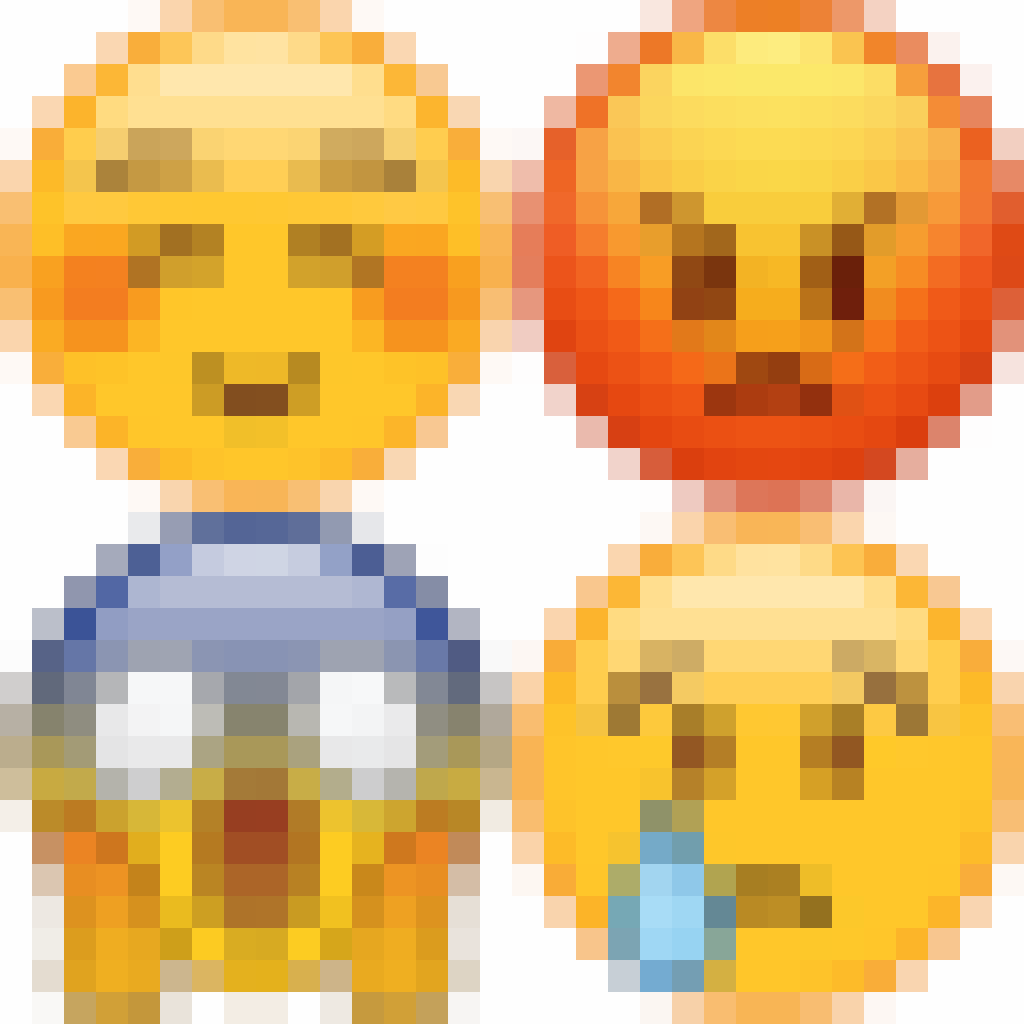

In [6]:
def save_image(image,filename='image.png',scale=None):

    img = Image.new('RGB',(L,L))

    for x in range(img.size[0]):
        for y in range(img.size[1]):
            img.load()[x,y] = image[x,y]

    if scale:
        img = img.resize((1024,1024))

    img.save('outputs/'+filename)

save_image(rgb_dict,scale=[1024,1024],filename='image1.png')
display(Image.open('outputs/image1.png'))

In [7]:
import numpy as np


grid = {} #creater math representation of grid for the big square pixxels
for y in range(L):
    for x in range(L):
        grid[(x,y)] = ''

for (x,y) in grid:
    for j in range(n):
        if (j%2)==0:
            xx = np.floor(x/2**(j/2))
            grid[(x,y)] = str( int( ( xx + np.floor(xx/2) )%2 ) ) + grid[(x,y)]
        else:
            yy = np.floor(y/2**((j-1)/2))
            grid[(x,y)] = str( int( ( yy + np.floor(yy/2) )%2 ) ) + grid[(x,y)]



In [8]:
def image2state(image,grid): #convcert the image to a quantum state - superposition of the different pixels for each R G B
    
    N = len(grid)
 
    state = [[0]*N,[0]*N,[0]*N] # different states for R, G and B

    for pos in image:
        for j in range(3):
            state[j][ int(grid[pos],2) ] = np.sqrt( image[pos][j] ) # amplitude is square root of colour value

    for j in range(3):        
        Z = sum(np.absolute(state[j])**2)
        state[j] = [amp / np.sqrt(Z) for amp in state[j]] # amplitudes are normalized
        
    return state


state = image2state(rgb_dict,grid)


In [9]:
from qiskit import *

backend = Aer.get_backend('statevector_simulator')

In [10]:
def ket2counts (ket): 
    counts = {}
    N=len(ket)
    n=int(np.log(N)/np.log(2))
    for j in range(N):
        string = bin(j)[2:]
        string = '0'*(n-len(string)) + string
        counts[string] = np.absolute(ket[j])**2
    return counts

In [11]:
q = QuantumRegister(n)

counts = []
for j in range(3):
    qc = QuantumCircuit(q)
    qc.initialize(state[j],q)
    job = execute(qc,backend)
    counts.append(ket2counts(job.result().get_statevector()))



In [12]:
def counts2image(counts,grid):
    
    image = { pos:[0,0,0] for pos in grid}

    for j in range(3):

        rescale = 255/max(counts[j].values()) # rescale so that largest probability becomes value of 255

        for pos in image:
            try:
                image[pos][j] = int( rescale*counts[j][grid[pos]] )
            except:
                image[pos][j] = int( rescale*counts[j][grid[pos]] )

    for pos in image:
        image[pos] = tuple(image[pos])

    return image




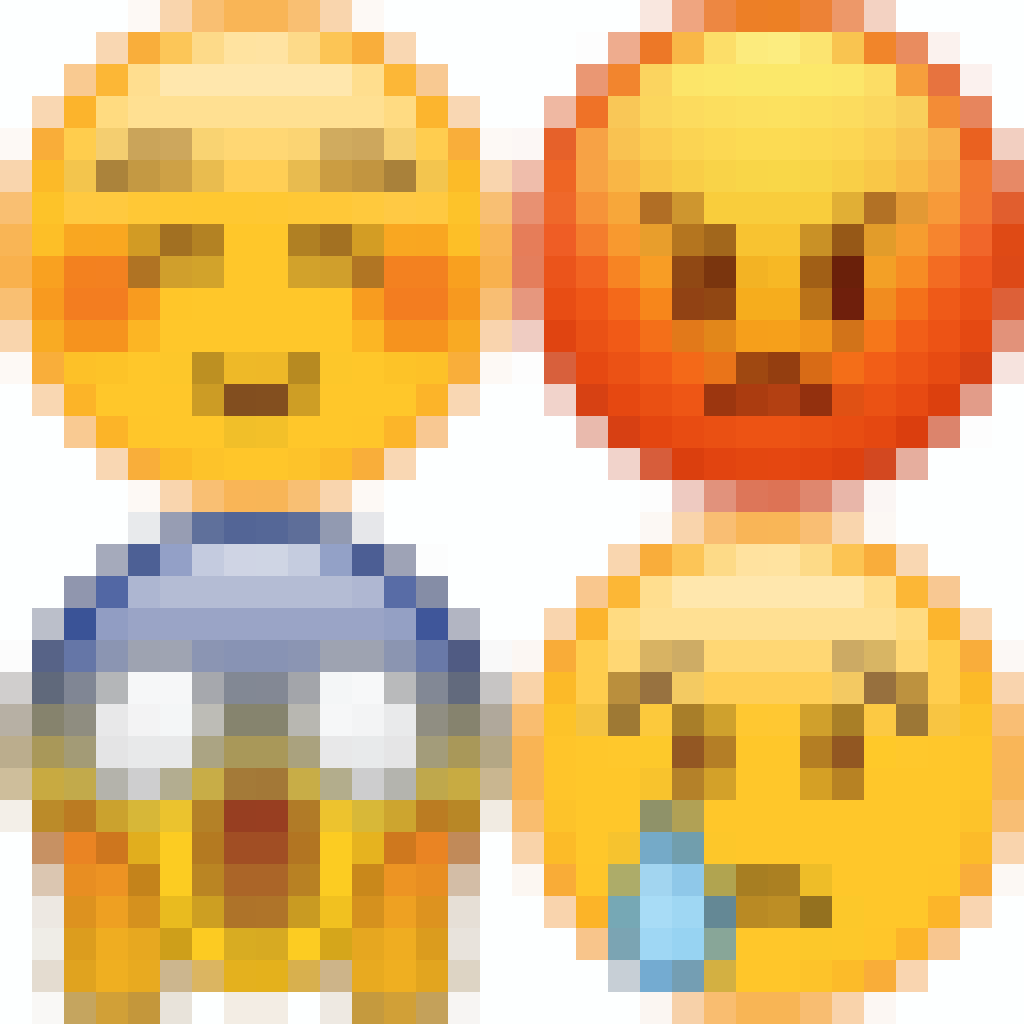

In [13]:
save_image( counts2image(counts,grid), scale=[300,300], filename='image2.png' )
display(Image.open('outputs/image2.png'))

In [14]:
#animation starts here
frame_num = 100


In [16]:
from apng import APNG
import os

state = image2state(rgb_dict,grid)

filenames = []
for f in range(frame_num):
        
    circuits = []
    for j in range(3):
        qc = QuantumCircuit(q)
        qc.initialize(state[j],q)
        qc.rx(2*np.pi*f/frame_num,q)#change the rotates on the register to alter the animation
        circuits.append( qc )

    job = execute(circuits, backend)

    counts = []
    for j in range(3):
        counts.append( ket2counts( job.result().get_statevector(circuits[j]) ) )
        
    frame = counts2image(counts,grid)
    
    filename = 'frame_'+str(f)+'.png'
    save_image( counts2image(counts,grid), scale=[300,300], filename=filename)
    filenames.append( 'outputs/' + filename )

APNG.from_files(filenames,delay=250).save('outputs/happy_angry_scared_sad_2.png')

#for file in filenames:
#   os.remove(file)

![](outputs/happy_angry_scared_sad_2.png)